### Test with passing long sequence to transformer and then combining with short embedding with a mask of entire sequence.

**`That is. Long Sequence + Long Mask -> Long Transformer. Then (Long Transformer o/p + Short Embedding) + full mask -> Overall Transformer Output`**

In [1]:
import pandas as pd
from tqdm import tqdm
import pickle
import numpy as np
tqdm.pandas()

In [2]:
df = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["uid", "sid", "rating", "timestamp"])

C:\Users\roro\AppData\Local\Temp\ipykernel_26736\2876192146.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["uid", "sid", "rating", "timestamp"])


### The ratings data

In [ ]:
df.head()

,uid,sid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### Converting ratings to implicit

In [3]:
df = df[df['rating'] >= 0]
df.head()
df.size

4000836

### Filter Triplets?

In [4]:
item_sizes = df.groupby('sid').size()
good_items = item_sizes.index[item_sizes >= 0]
df = df[df['sid'].isin(good_items)]

user_sizes = df.groupby('uid').size()
good_users = user_sizes.index[user_sizes >= 5]
df = df[df['uid'].isin(good_users)]

df.head()

,uid,sid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### Densifying index

In [5]:
umap = {u: i for i, u in enumerate(set(df['uid']))}
smap = {s: i for i, s in enumerate(set(df['sid']))}
df['uid'] = df['uid'].map(umap)
df['sid'] = df['sid'].map(smap)

df.head()

,uid,sid,rating,timestamp
0,0,1104,5,978300760
1,0,639,3,978302109
2,0,853,3,978301968
3,0,3177,4,978300275
4,0,2162,5,978824291


In [6]:
user_count = len(umap)
item_count = len(smap)
print(user_count, item_count)

6040 3706


#### Delete df if just training

In [ ]:
del df

### Splitting Dataframe into train, test and val

In [27]:
user_group = df.groupby('uid')
user2items = user_group.progress_apply(lambda x: list(x.sort_values('timestamp')['sid']))

100%|██████████| 6040/6040 [00:01<00:00, 5768.86it/s]


In [28]:
user_count = len(umap)
train, val, test = {}, {}, {}
for user in range(user_count):
    items = user2items[user]
    train[user]= items


In [ ]:
# Convert train dict into a pandas series with two columns: 
train_df = pd.Series(train).to_frame(name="seq")
# Add a column user with the user id
train_df['user'] = train_df.index
# Make user column first
train_df = train_df[['user', 'seq']]
train_df.head()

,user,seq
0,0,"[2969, 1574, 957, 1178, 2147, 1658, 3177, 1117..."
1,1,"[1108, 1127, 1120, 2512, 1201, 2735, 1135, 110..."
2,2,"[579, 2651, 3301, 1788, 1781, 1327, 1174, 1279..."
3,3,"[1120, 1025, 3235, 3294, 466, 253, 1106, 1108,..."
4,4,"[2512, 858, 847, 346, 1158, 2007, 2651, 1050, ..."


In [ ]:
# Find users with sequence length < 25
train_df['seq'].apply(len).value_counts(sort=True, ascending=False)


21      91
20      86
23      81
24      81
22      77
        ..
903      1
447      1
582      1
1323     1
888      1
Name: seq, Length: 743, dtype: int64

In [29]:
user_arange = np.arange(0, user_count)
user_arange.shape

(6040,)

In [37]:
train_df = pd.DataFrame(user_arange, columns=['user'])
train_df['seq'] = [[] for _ in range(user_count)]

In [38]:
# Copy indices to new dataframe

val_df = pd.DataFrame(user_arange, columns=['user'])
# Add new column seq
# Add new column seq with empty lists
val_df['seq'] = [[] for _ in range(user_count)]

In [39]:
test_df = pd.DataFrame(user_arange, columns=['user'])
test_df['seq'] = [[] for _ in range(user_count)]

In [33]:
max_len = 50

### This is method 1 of creating the val and test sets


In [40]:
from tqdm import trange




def create_sequences(window_size, step_size):
    for i in trange(0, user_count):
        train_sequences = []
        val_sequences = []
        test_sequences = []
        values = train[i]
        start_index = 0
        while True:
            end_index = start_index + window_size
            seq = values[start_index:end_index]
            if len(seq) < window_size:
                # If sequence length is less than half of the window size, dont use it
                if len(seq) < window_size / 2:
                    break
                train_sequences.append(seq[:-2])
                val_sequences.append(seq[-2:-1])
                test_sequences.append(seq[-1:])
                break
            train_sequences.append(seq[:-2])
            val_sequences.append(seq[-2:-1])
            test_sequences.append(seq[-1:])
            start_index += step_size
        # Set the sequence to the correct row
        train_df.at[i, 'seq'] = train_sequences
        val_df.at[i, 'seq'] = val_sequences
        test_df.at[i, 'seq'] = test_sequences



create_sequences(max_len, max_len)
# train_df['seq'] = train_df['seq'].progress_apply(lambda x: create_sequences(x, max_len, max_len))

# Remove empty sequences
train_df = train_df[train_df['seq'].map(len) > 0]
val_df = val_df[val_df['seq'].map(len) > 0]
test_df = test_df[test_df['seq'].map(len) > 0]
train_df.head()

100%|██████████| 6040/6040 [00:00<00:00, 6119.57it/s]


,user,seq
0,0,"[[2969, 1574, 957, 1178, 2147, 1658, 3177, 111..."
1,1,"[[1108, 1127, 1120, 2512, 1201, 2735, 1135, 11..."
2,2,"[[579, 2651, 3301, 1788, 1781, 1327, 1174, 127..."
4,4,"[[2512, 858, 847, 346, 1158, 2007, 2651, 1050,..."
5,5,"[[2857, 1826, 851, 1120, 3301, 978, 1336, 367,..."


In [41]:
val_df.head()

,user,seq
0,0,[[740]]
1,1,"[[3341], [1826], [1420]]"
2,2,[[3622]]
4,4,"[[2516], [2099], [1581], [1371]]"
5,5,[[963]]


In [42]:
test_df.head()

,user,seq
0,0,[[2162]]
1,1,"[[2853], [2086], [1737]]"
2,2,[[101]]
4,4,"[[2775], [567], [699], [279]]"
5,5,[[853]]


In [43]:
train_df = train_df[["user", "seq"]].explode("seq", ignore_index=True)
train_df

,user,seq
0,0,"[2969, 1574, 957, 1178, 2147, 1658, 3177, 1117..."
1,1,"[1108, 1127, 1120, 2512, 1201, 2735, 1135, 110..."
2,1,"[258, 2120, 576, 2856, 1161, 1152, 3457, 1153,..."
3,1,"[1271, 2234, 627, 1273, 1428, 1623, 2296, 1286..."
4,2,"[579, 2651, 3301, 1788, 1781, 1327, 1174, 1279..."
...,...,...
20116,6039,"[1068, 1096, 2857, 1110, 1780, 2825, 1193, 102..."
20117,6039,"[2541, 2094, 1842, 2176, 2773, 2597, 3291, 182..."
20118,6039,"[1155, 1146, 1139, 107, 849, 297, 1118, 2656, ..."
20119,6039,"[3238, 2462, 324, 838, 855, 917, 2762, 1500, 1..."


In [44]:
val_df = val_df[["user", "seq"]].explode("seq", ignore_index=True)
val_df

,user,seq
0,0,[740]
1,1,[3341]
2,1,[1826]
3,1,[1420]
4,2,[3622]
...,...,...
20116,6039,[2803]
20117,6039,[713]
20118,6039,[1171]
20119,6039,[1559]


In [45]:
test_df = test_df[["user", "seq"]].explode("seq", ignore_index=True)
test_df

,user,seq
0,0,[2162]
1,1,[2853]
2,1,[2086]
3,1,[1737]
4,2,[101]
...,...,...
20116,6039,[2540]
20117,6039,[847]
20118,6039,[1186]
20119,6039,[1157]


### This is method 2 for creating val and test sets.

In [20]:
user_count = len(umap)
train, val, test = {}, {}, {}
for user in range(user_count):
    items = user2items[user]
    train[user], val[user], test[user] = items[:-2], items[-2:-1], items[-1:]


In [ ]:
def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            # If sequence length is less than half of the window size, dont use it
            if len(seq) < window_size / 2:
                break
            sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences

train_df['seq'] = train_df['seq'].progress_apply(lambda x: create_sequences(x, max_len, max_len))

# Remove empty sequences
train_df = train_df[train_df['seq'].map(len) > 0]
train_df.head()

## **End of Method 2**

In [ ]:
max_len = 25

In [ ]:
# Find a user with a sequence length < 25
train_df[train_df['seq'].apply(len) < 25]


,user,seq
0,0,"[2969, 1574, 957, 1178, 2147, 1658, 3177, 1117..."
1,0,"[2592, 1195, 2557, 1154, 639, 2710, 517, 2898,..."
2,1,"[1108, 1127, 1120, 2512, 1201, 2735, 1135, 110..."
3,1,"[2889, 1259, 1106, 1777, 859, 1773, 1012, 1782..."
4,1,"[576, 2856, 1161, 1152, 3457, 1153, 1775, 2046..."
...,...,...
38599,6039,"[1830, 1162, 1184, 1144, 1129, 1749, 1123, 103..."
38600,6039,"[863, 689, 1084, 1572, 1765, 1113, 869, 24, 10..."
38601,6039,"[1031, 976, 148, 3493, 3441, 1124, 2410, 2443,..."
38602,6039,"[1161, 1499, 2058, 28, 2246, 3313, 2711, 1132,..."


In [ ]:
# dataset = {
#     'val': val,
#     'test': test,
#     'umap': umap,
#     'smap': smap
# }



In [21]:
import os


os.mkdir(f'data/lstr/seqlen-{max_len}')

In [46]:
# Save datasets as pickle
train_df.to_pickle(f"data/lstr/seqlen-{max_len}/train.pkl")
val_df.to_pickle(f"data/lstr/seqlen-{max_len}/val.pkl")
test_df.to_pickle(f"data/lstr/seqlen-{max_len}/test.pkl")


In [ ]:
# folder_name = '{}_min_rating{}-min_uc{}-min_sc{}-split{}_except_train' \
#             .format('ml-1m', 0, 5, 0, 'leave_one_out')

# with open('data/lstr/{}.pkl'.format(folder_name), 'wb') as f:
#     pickle.dump(dataset, f)

### Get negative train samples

In [47]:
from pathlib import Path


dataset_folder = Path(f'data/lstr/seqlen-{max_len}')
dataset_filename = '{}_min_rating{}-min_uc{}-min_sc{}-split{}'.format('ml-1m', 3, 5, 0, 'leave_one_out')
dataset_file = dataset_folder.joinpath(dataset_filename + '.pkl')

### Load Dataset from pkl

In [48]:
# dataset: dict[str, dict[str, list[int]]] = pickle.load(open(dataset_file, 'rb'))
train_df: pd.DataFrame = pd.read_pickle(dataset_folder.joinpath('train.pkl'))
val_df: pd.DataFrame = pd.read_pickle(dataset_folder.joinpath('val.pkl'))
test_df: pd.DataFrame = pd.read_pickle(dataset_folder.joinpath('test.pkl'))
# val = dataset['val']
# test = dataset['test']
# umap = dataset['umap']
# smap = dataset['smap']
# user_count = len(umap)
# item_count = len(smap)

In [49]:
from tqdm import trange


def generate_negative_samples(seed: int, sample_size: int = 100) -> dict[str, list[int]]:
    np.random.seed(seed)
    negative_samples = {}
    # If sample size is 0 return;
    if sample_size == 0: return
    for row in trange(len(train_df)):
        seen = set(train_df.iloc[row]['seq'])
        seen.update(val_df.iloc[row]['seq'])
        seen.update(test_df.iloc[row]['seq'])
        
        samples = []
        for _ in range(sample_size):
            item = np.random.choice(item_count) + 1
            while item in seen or item in samples:
                item = np.random.choice(item_count) + 1
            samples.append(item)
        
        negative_samples[row] = samples
    
    return negative_samples

In [50]:
negative_train_samples = generate_negative_samples(0, 0)
negative_test_samples = generate_negative_samples(42, max_len)

100%|██████████| 20121/20121 [00:13<00:00, 1528.25it/s]


### Save Negative train samples

In [51]:
negative_test_save_file_path = '{}-sample_size{}-seed{}-{}.pkl'.format('random', max_len, 42, 'test')
negative_test_save_file = dataset_folder.joinpath(negative_test_save_file_path)



In [52]:
with negative_test_save_file.open('wb') as f:
    pickle.dump(negative_test_samples, f)

### Load negative samples

In [ ]:
with negative_test_save_file.open('rb') as f:
    negative_test_samples = pickle.load(f)

Epoch 0:   9%|▊         | 137/1568 [09:41<1:41:10,  4.24s/it, loss=nan, v_num=11, train/ce=nan.0]


In [ ]:
type(negative_test_samples)

dict

In [53]:
import torch
import torch.utils.data as data_utils
import torch.backends.cudnn as cudnn
import pytorch_lightning as pl
import torch.nn as nn
import random

e:\Coding\bst-lstr\bst\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [55]:
class BertTrainDataset(data_utils.Dataset):
    def __init__(self, max_len: int, mask_prob: float, mask_token: int, num_items: int, rng: random.Random, long_len: int):
        # self.users = sorted(self.u2seq.keys())
        self.max_len = max_len
        self.train_df = pd.read_pickle(f'data/lstr/seqlen-{max_len}/train.pkl')
        self.mask_prob = mask_prob
        self.mask_token = mask_token
        self.num_items = num_items
        self.rng = rng
        self.long_len = long_len

    def __len__(self):
        return len(self.train_df)

    def __getitem__(self, index: int):
        seq = self.train_df.seq[index]

        tokens: list[int] = []
        labels: list[int] = []
        for s in seq:
            prob = self.rng.random()
            if prob < self.mask_prob:
                prob /= self.mask_prob

                if prob < 0.8:
                    tokens.append(self.mask_token)
                elif prob < 0.9:
                    tokens.append(self.rng.randint(1, self.num_items))
                else:
                    tokens.append(s)

                labels.append(s)
            else:
                tokens.append(s)
                labels.append(0)

        # May not need this since the sequences are already cut.
        # tokens = tokens[-self.max_len:]
        # labels = labels[-self.max_len:]

        mask_len = self.max_len - len(tokens)

        tokens = [0] * mask_len + tokens
        labels = [0] * mask_len + labels

        # Split the sequences into two parts.
        # Long and short sequence.
        long_tokens = tokens[:self.long_len]
        short_tokens = tokens[self.long_len:]

        return torch.LongTensor(long_tokens), torch.LongTensor(short_tokens), torch.LongTensor(labels)


In [ ]:
train_ds = BertTrainDataset(10, 0.15, item_count+1, item_count, random.Random(0), 6)
train_ds.__getitem__(0)[2].size()

torch.Size([10])

### Two lines of thought:

#### 1. We could use **leave_one_out** on each sequence generated and get a validation and test set for each row in `train_df`.
- For example, we could have:
  - `seq_length = 26`
  - `train_short_len = 6`
  - `train_long_len = 18`
  - `val_len = 1`
  - `test_len = 1`

#### 2. We could use **leave_one_out** on the entire train set per user before generating sequences we create a validation and test set. This would mean using the same validation and test for all sequences for a given user.
- For example, we could have:
  - `seq_length = 25`
  - `train_short_len = 5`
  - `train_long_len = 20`
  - `val_len = 1` taken from the entire train set
  - `test_len = 1` taken from the entire train set

### Eval Dataset (Val and Test)

In [56]:
class BertEvalDataset(data_utils.Dataset):
    def __init__(self, answer: str, max_len: int, mask_token: int, negative_samples: dict[str, list[int]], long_len: int) -> None:
        self.train_df = pd.read_pickle(f'data/lstr/seqlen-{max_len}/train.pkl')
        if answer == 'val':
            self.df = pd.read_pickle(f'data/lstr/seqlen-{max_len}/val.pkl')
        elif answer == 'test':
            self.df = pd.read_pickle(f'data/lstr/seqlen-{max_len}/test.pkl')
        self.max_len = max_len
        self.mask_token = mask_token
        self.negative_samples = negative_samples
        self.long_len = long_len

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, index: int) -> tuple[torch.LongTensor, torch.LongTensor, torch.LongTensor]:
        
        seq = self.train_df.iloc[index]['seq']
        answer = self.df.iloc[index]['seq']
        negs = self.negative_samples[index]

        candidates = answer + negs
        labels = [1] * len(answer) + [0] * len(negs)

        seq = seq + [self.mask_token]
        seq = seq[-self.max_len:]
        padding_len = self.max_len - len(seq)
        seq = [0] * padding_len + seq

        long_seq = seq[:self.long_len]
        short_seq = seq[self.long_len:]

        return torch.LongTensor(long_seq), torch.LongTensor(short_seq), torch.LongTensor(candidates), torch.LongTensor(labels)


In [ ]:
test_ds = BertEvalDataset('val', 10, item_count+1, negative_test_samples, 6)
test_ds.__getitem__(0)[3].size()

torch.Size([11])

In [57]:
def fix_random_seed_as(random_seed: int) -> None:
    random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

In [58]:
class PositionalEmbedding(pl.LightningModule):
    def __init__(self, max_len: int, d_model: int) -> None:
        super().__init__()

        # Compute the positional encodings once in log space.
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1)

In [59]:
class BERTEmbedding(pl.LightningModule):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size: int, embed_size: int, max_len: int, dropout: float = 0.1) -> None:
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """
        super().__init__()
        self.token = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.position = PositionalEmbedding(max_len=max_len, d_model=embed_size)
        # self.segment = SegmentEmbedding(embed_size=self.token.embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    def forward(self, sequence: torch.Tensor) -> torch.Tensor:
        x: torch.Tensor = self.token(sequence) + self.position(sequence)  # + self.segment(segment_label)
        return self.dropout(x)

In [ ]:
def set_template(args):
    if args.template is None:
        return

    elif args.template.startswith('train_bert'):
        args.mode = 'train'

        args.dataset_code = 'ml-' + input('Input 1 for ml-1m, 20 for ml-20m: ') + 'm'
        args.min_rating = 0 if args.dataset_code == 'ml-1m' else 4
        args.min_uc = 5
        args.min_sc = 0
        args.split = 'leave_one_out'

        args.dataloader_code = 'bert'
        batch = 64
        args.train_batch_size = batch
        args.val_batch_size = batch
        args.test_batch_size = batch

        args.train_negative_sampler_code = 'random'
        args.train_negative_sample_size = 0
        args.train_negative_sampling_seed = 0
        args.test_negative_sampler_code = 'random'
        args.test_negative_sample_size = 100
        args.test_negative_sampling_seed = 98765

        args.trainer_code = 'bert'
        args.device = 'cuda'
        args.num_gpu = 1
        args.device_idx = '0'
        args.optimizer = 'Adam'
        args.lr = 0.001
        args.enable_lr_schedule = True
        args.decay_step = 25
        args.gamma = 1.0
        args.num_epochs = 100 if args.dataset_code == 'ml-1m' else 200
        args.metric_ks = [1, 5, 10, 20]
        args.best_metric = 'NDCG@10'

        args.model_code = 'bert'
        args.model_init_seed = 0

        args.bert_dropout = 0.1
        args.bert_hidden_units = 256
        args.bert_mask_prob = 0.15
        args.bert_max_len = 100
        args.bert_num_blocks = 2
        args.bert_num_heads = 4

In [60]:
from torch import NumberType


def recalls_and_ndcgs_for_ks(scores: torch.Tensor, labels: torch.Tensor, ks: list[int]):
    metrics: dict[str, NumberType] = {}

    # Why is this being done?
    # scores = scores
    # labels = labels
    answer_count = labels.sum(1)

    labels_float = labels.float()
    rank = (-scores).argsort(dim=1)
    cut = rank
    for k in sorted(ks, reverse=True):
        cut = cut[:, :k]
        hits = labels_float.gather(1, cut)
        """
            Recall at k is the proportion of relevant items found in the top-k recommendations.
            Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
        """
        numerator = hits.sum(1)
        denominator = torch.min(torch.Tensor([k]).to(labels.device), labels.sum(1).float())
        metrics['Recall@%d' % k] = \
            (numerator / denominator).mean().cpu().item()

        """
            NDCG at k is the average of the normalized DCG scores of the top-k recommendations.
            NDCG@k = DCG@k / IDCG@k
            DCG@K = SUM( recc_i / log2(i + 1))
            IDCG@K = SUM( real_i / log2(i + 1))
        """
        position = torch.arange(2, 2+k)
        weights = 1 / torch.log2(position.float())
        # Discounted cumulative gain at k
        dcg = (hits * weights.to(hits.device)).sum(1)
        # Ideal discounted cumulative gain at k
        # idcg = (labels_float * weights.to(labels_float.device)).sum(1)
        idcg = torch.Tensor([weights[:min(int(n), k)].sum()
                            for n in answer_count]).to(dcg.device)
        # What is the above code doing
        ndcg = (dcg / idcg).mean()
        metrics['NDCG@%d' % k] = ndcg.cpu().item()

    return metrics

In [86]:
class BERT(pl.LightningModule):
    def __init__(self, args: dotdict):
        super().__init__()

        fix_random_seed_as(args.model_init_seed)
        # self.init_weights()

        self.args = args
        long_len: int = args.bert_long_len
        short_len: int = args.bert_short_len
        num_items: int = args.num_items
        n_layers: int = args.bert_num_blocks
        self.heads: int = args.bert_num_heads
        vocab_size: int = num_items + 2
        hidden: int = args.bert_hidden_units
        self.hidden = hidden
        self.metric_ks = args.metric_ks
        dropout: float = args.bert_dropout
        self.ce = nn.CrossEntropyLoss(ignore_index=0)
        # embedding for BERT, sum of positional, segment, token embeddings
        self.long_embedding = BERTEmbedding(
            vocab_size=vocab_size, embed_size=self.hidden, max_len=long_len, dropout=dropout)
        self.short_embedding = BERTEmbedding(
            vocab_size=vocab_size, embed_size=self.hidden, max_len=short_len, dropout=dropout)
        # multi-layers transformer blocks, deep network
        self.encoder = nn.TransformerEncoderLayer(hidden, self.heads, hidden * 4, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder, n_layers)
        self.out = nn.Linear(self.hidden, num_items + 1)

    def forward(self, long_seq: torch.Tensor, short_seq: torch.Tensor) -> torch.Tensor:
        full_seq = torch.cat([long_seq, short_seq], dim=1)
        full_mask = (full_seq == 0).unsqueeze(1).repeat(self.heads, full_seq.size(1), 1)
        long_mask = (long_seq == 0).unsqueeze(1).repeat(self.heads, long_seq.size(1), 1)
        long_seq = self.long_embedding(long_seq)
        long_output: torch.Tensor = self.transformer(long_seq, long_mask)


        # short_mask = (short_seq == 0).unsqueeze(1).repeat(self.heads, short_seq.size(1), 1)
        short_seq = self.short_embedding(short_seq)
        seq = torch.cat([long_output, short_seq], dim=1)
        # short_output: torch.Tensor = self.transformer(short_seq, short_mask)
        output: torch.Tensor = self.transformer(seq, full_mask)

        # output = torch.cat([long_output, short_output], dim=1)

        # output = output.masked_fill(torch.isnan(output), 0)
        return self.out(output)

    def init_weights(self):
        pass

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        batch_size = batch[0].size(0)
        long_seq, short_seq, labels = batch
        logits: torch.Tensor = self(long_seq, short_seq)

        logits = logits.view(-1, logits.size(-1))
        labels = labels.view(-1)
        loss: torch.Tensor = self.ce(logits, labels)
        # log_data = {
        #     'state_dict': (self._create_state_dict()),
        #     "train/ce": loss.item()
        # }
        self.log(
            "train/ce", loss, on_step=True, on_epoch=False, prog_bar=True
        )
        return loss

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int):
        long_seq, short_seq, candidates, labels = batch
        scores: torch.Tensor = self(long_seq, short_seq)
        scores = scores[:, -1, :]
        scores = scores.gather(1, candidates)
        metrics = recalls_and_ndcgs_for_ks(scores, labels, self.metric_ks)

        return metrics

    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int) -> dict[str, NumberType]:
        long_seq, short_seq, candidates, labels = batch
        scores: torch.Tensor = self(long_seq, short_seq)
        scores = scores[:, -1, :]
        scores = scores.gather(1, candidates)
        metrics = recalls_and_ndcgs_for_ks(scores, labels, self.metric_ks)

        # self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
        return metrics

    def validation_epoch_end(self, outputs: list) -> None:
        # outputs is a list of dicts
        avg_metrics = {}
        for metric in outputs[0].keys():
            avg_metrics[metric] = torch.mean(torch.FloatTensor([x[metric] for x in outputs]))

        self.log_dict(avg_metrics, on_step=False, on_epoch=True, prog_bar=True)

        
    
    def test_epoch_end(self, outputs: list[dict[str, NumberType]]) -> None:
        # outputs is a list of dicts
        metric_names = outputs[0].keys()
        avg_metrics = dict.fromkeys(metric_names, [])
        for output in outputs:
            for metric_name in metric_names:
                avg_metrics[metric_name].append(output[metric_name])
        
        for metric_name in metric_names:
            avg_metrics[metric_name] = torch.mean(torch.stack(avg_metrics[metric_name]))
        
        self.log_dict(avg_metrics, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        if self.args['optimizer'].lower() == 'adam':
            return torch.optim.Adam(self.parameters(), lr=self.args['lr'], weight_decay=self.args['weight_decay'])
        elif self.args['optimizer'].lower() == 'sgd':
            return torch.optim.SGD(self.parameters(), lr=self.args['lr'], weight_decay=self.args['weight_decay'], momentum=self.args['momentum'])
        else:
            raise ValueError('Optimizer not supported')

    def _create_state_dict(self):
        return {
            'model_state_dict': self.model.module.state_dict() if self.is_parallel else self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }
    
    def setup(self, stage=None):
        self.train_dataset = BertTrainDataset(max_len, 0.9, item_count+1, item_count, random.Random(0), 40)
        self.val_dataset = BertEvalDataset('val', max_len, item_count+1, negative_test_samples, 40)
        self.test_dataset = BertEvalDataset('test', max_len, item_count+1, negative_test_samples, 40)

    
    def train_dataloader(self):
        return data_utils.DataLoader(
            self.train_dataset,
            batch_size=128,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        return data_utils.DataLoader(
            self.val_dataset,
            batch_size=128,
            shuffle=False,
            pin_memory=True,
        )

    def test_dataloader(self):
        return data_utils.DataLoader(
            self.test_dataset,
            batch_size=128,
            shuffle=False,
            pin_memory=True,
        )


In [87]:
args = {
    'bert_max_len': max_len,
    'bert_long_len': 40,
    'bert_short_len': 10,
    'num_items': item_count,
    'bert_num_blocks': 2,
    'bert_num_heads': 4,
    'bert_hidden_units': 64,
    'bert_dropout': 0.1,
    'model_init_seed': 42,
    'bert_mask_prob': 0.9,
    'metric_ks': [1, 5, 10],
    'lr': 0.001,
    'weight_decay': 0.0,
    'optimizer': 'Adam',
}

args = dotdict(args)

In [88]:
from pytorch_lightning.profiler import SimpleProfiler
# if model: del model
model = BERT(args)
profiler = SimpleProfiler()
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=50, profiler=profiler)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                    | Params 
-------------------------------------------------------------
0 | ce              | CrossEntropyLoss        | 0      
1 | long_embedding  | BERTEmbedding           | 239 K  
2 | short_embedding | BERTEmbedding           | 237 K  
3 | encoder         | TransformerEncoderLayer | 50.0 K 
4 | transformer     | TransformerEncoder      | 100.0 K
5 | out             | Linear                  | 240 K  
-------------------------------------------------------------
868 K     Trainable params
0         Non-trainable params
868 K     Total params
3.475     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

e:\Coding\bst-lstr\bst\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


e:\Coding\bst-lstr\bst\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 48:  62%|██████▏   | 197/316 [00:06<00:03, 32.56it/s, loss=6.08, v_num=35, train/ce=6.210, Recall@10=0.870, NDCG@10=0.615, Recall@5=0.751, NDCG@5=0.576, Recall@1=0.376, NDCG@1=0.376]

e:\Coding\bst-lstr\bst\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
%pip install seaborn

In [127]:
ndcgs_50 = [0.676,
            0.714,
            0.696,
            0.691,
            0.689,
            0.686,
            0.667,
            0.654,
            0.615]

recalls_50 = [0.898,
              0.916,
              0.906,
              0.903,
              0.902,
              0.9,
              0.894,
              0.888,
              0.87]

p_values = [0.1,
            0.2,
            0.3,
            0.4,
            0.5,
            0.6,
            0.7,
            0.8,
            0.9]

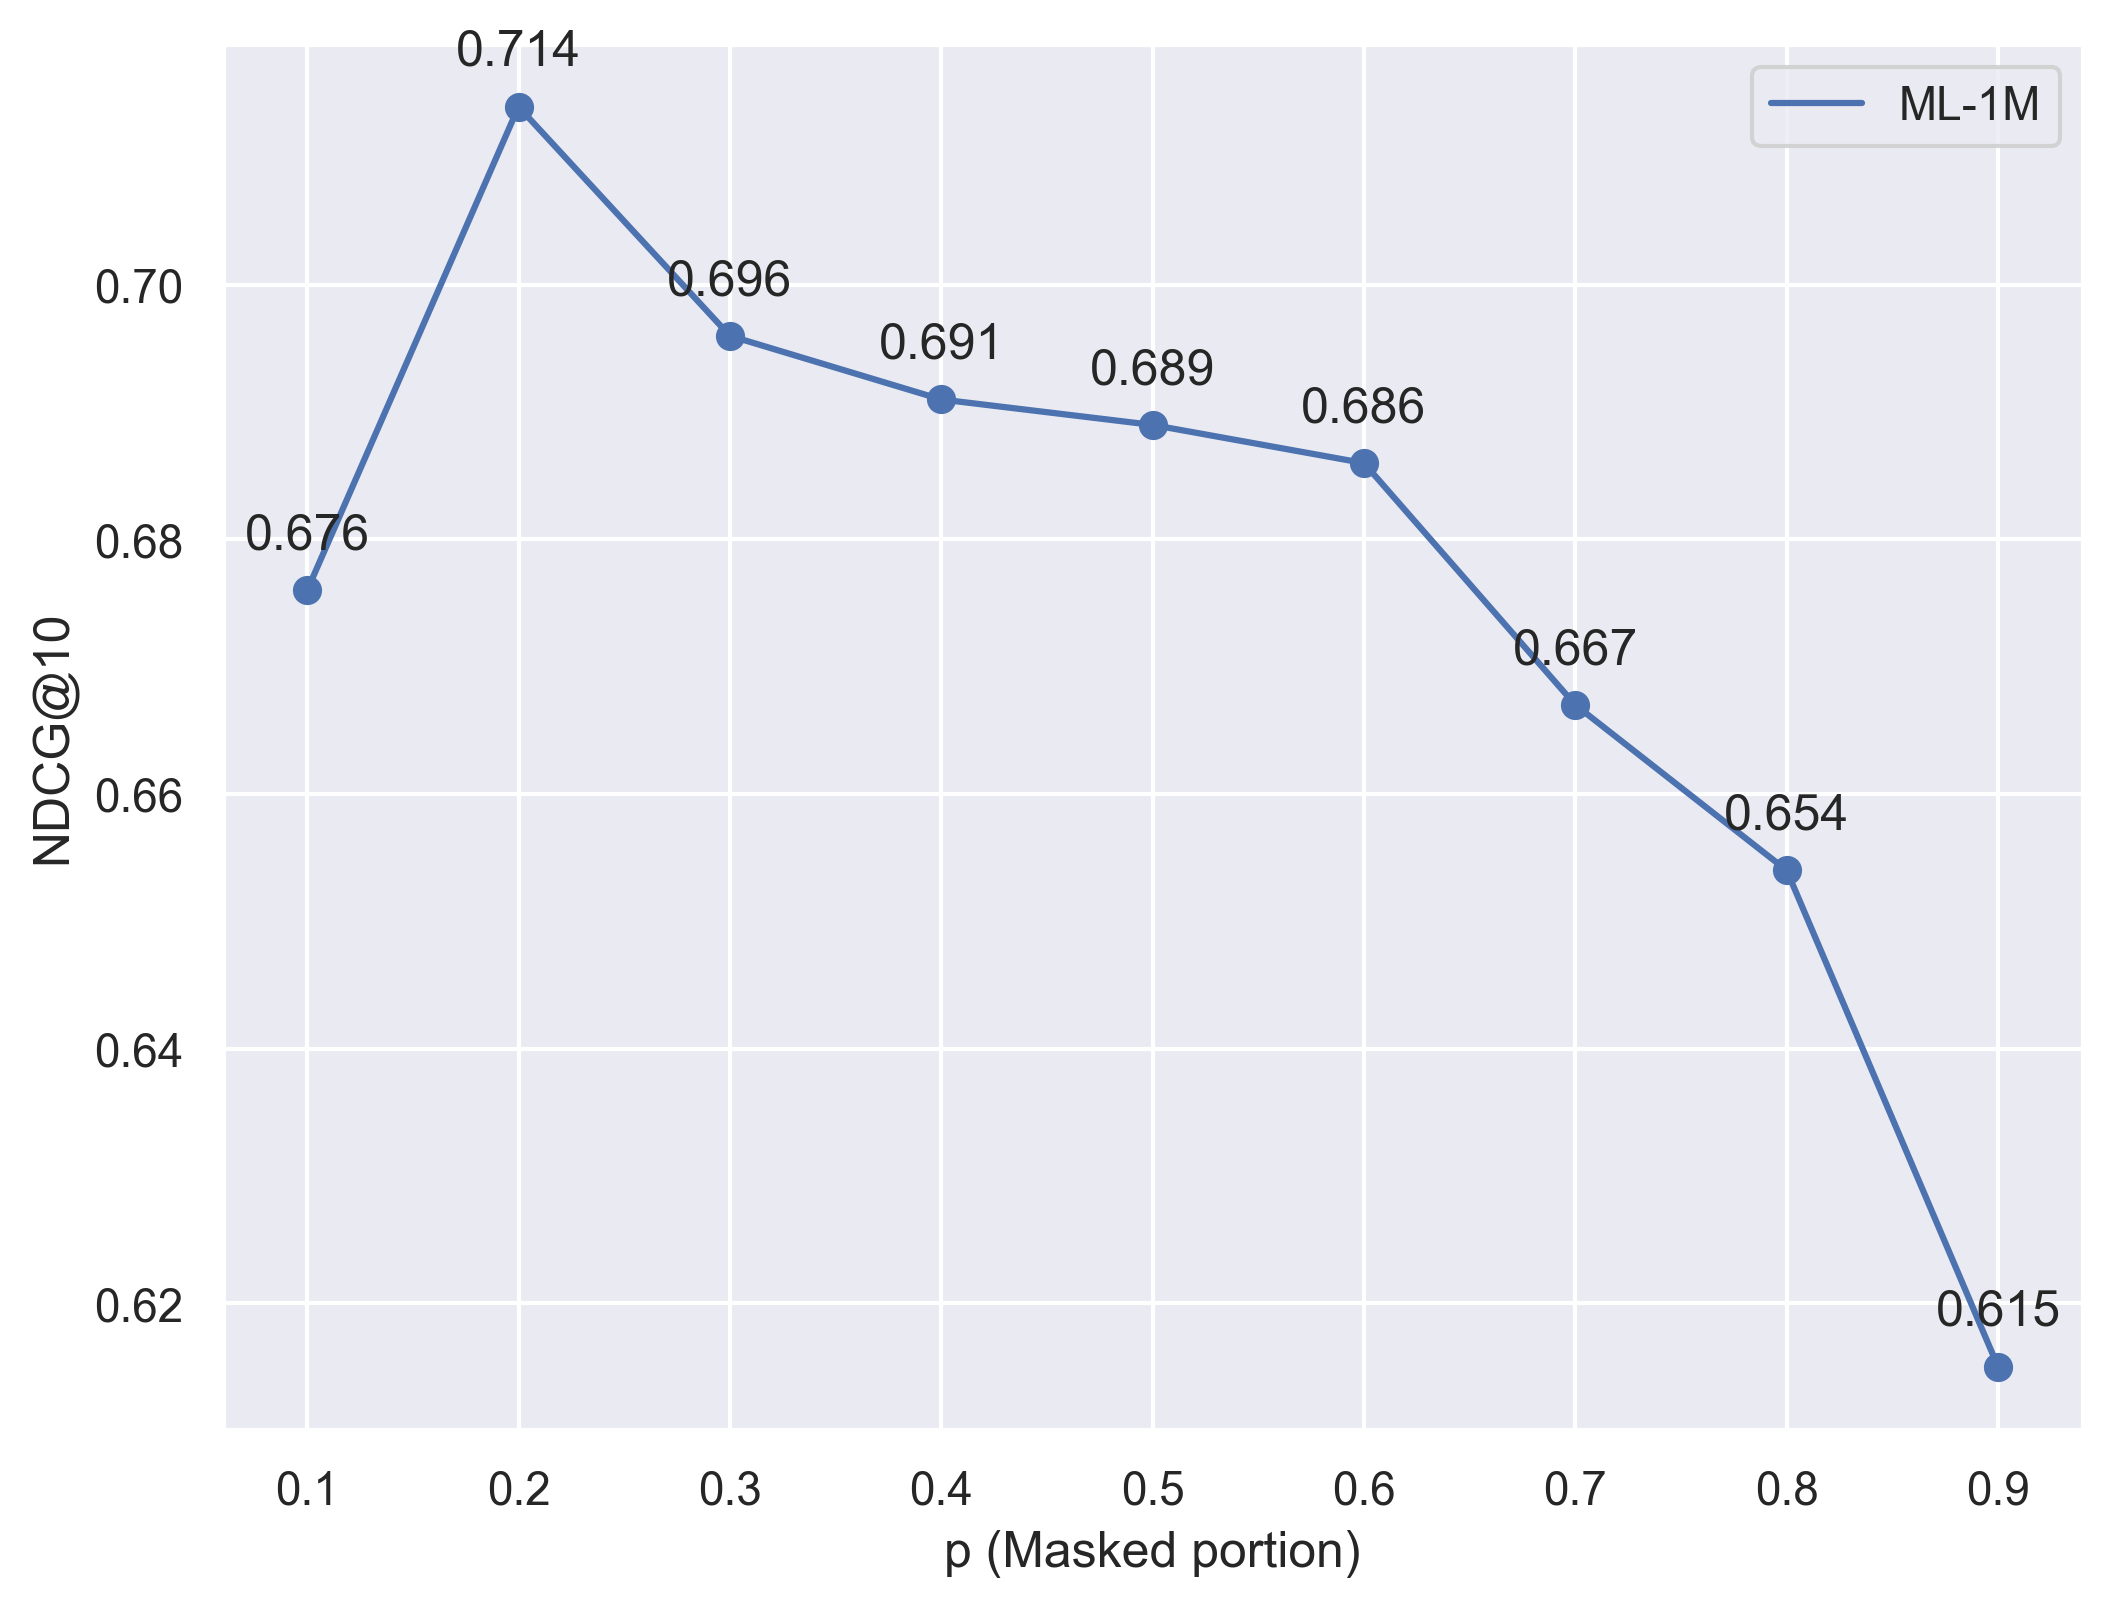

In [128]:
# Plot these values on a line chart with matplotlib
import matplotlib.pyplot as plt
# Without seaborn
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=300)
plt.plot(p_values, ndcgs_50, label='ML-1M')


# Highlight each point with a dot
plt.scatter(p_values, ndcgs_50)

# Show the value next to each point with text
for x, y in zip(p_values, ndcgs_50):
    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.xlabel('p (Masked portion)')
plt.ylabel('NDCG@10')
plt.legend()
plt.show()

# Label the axes with sns



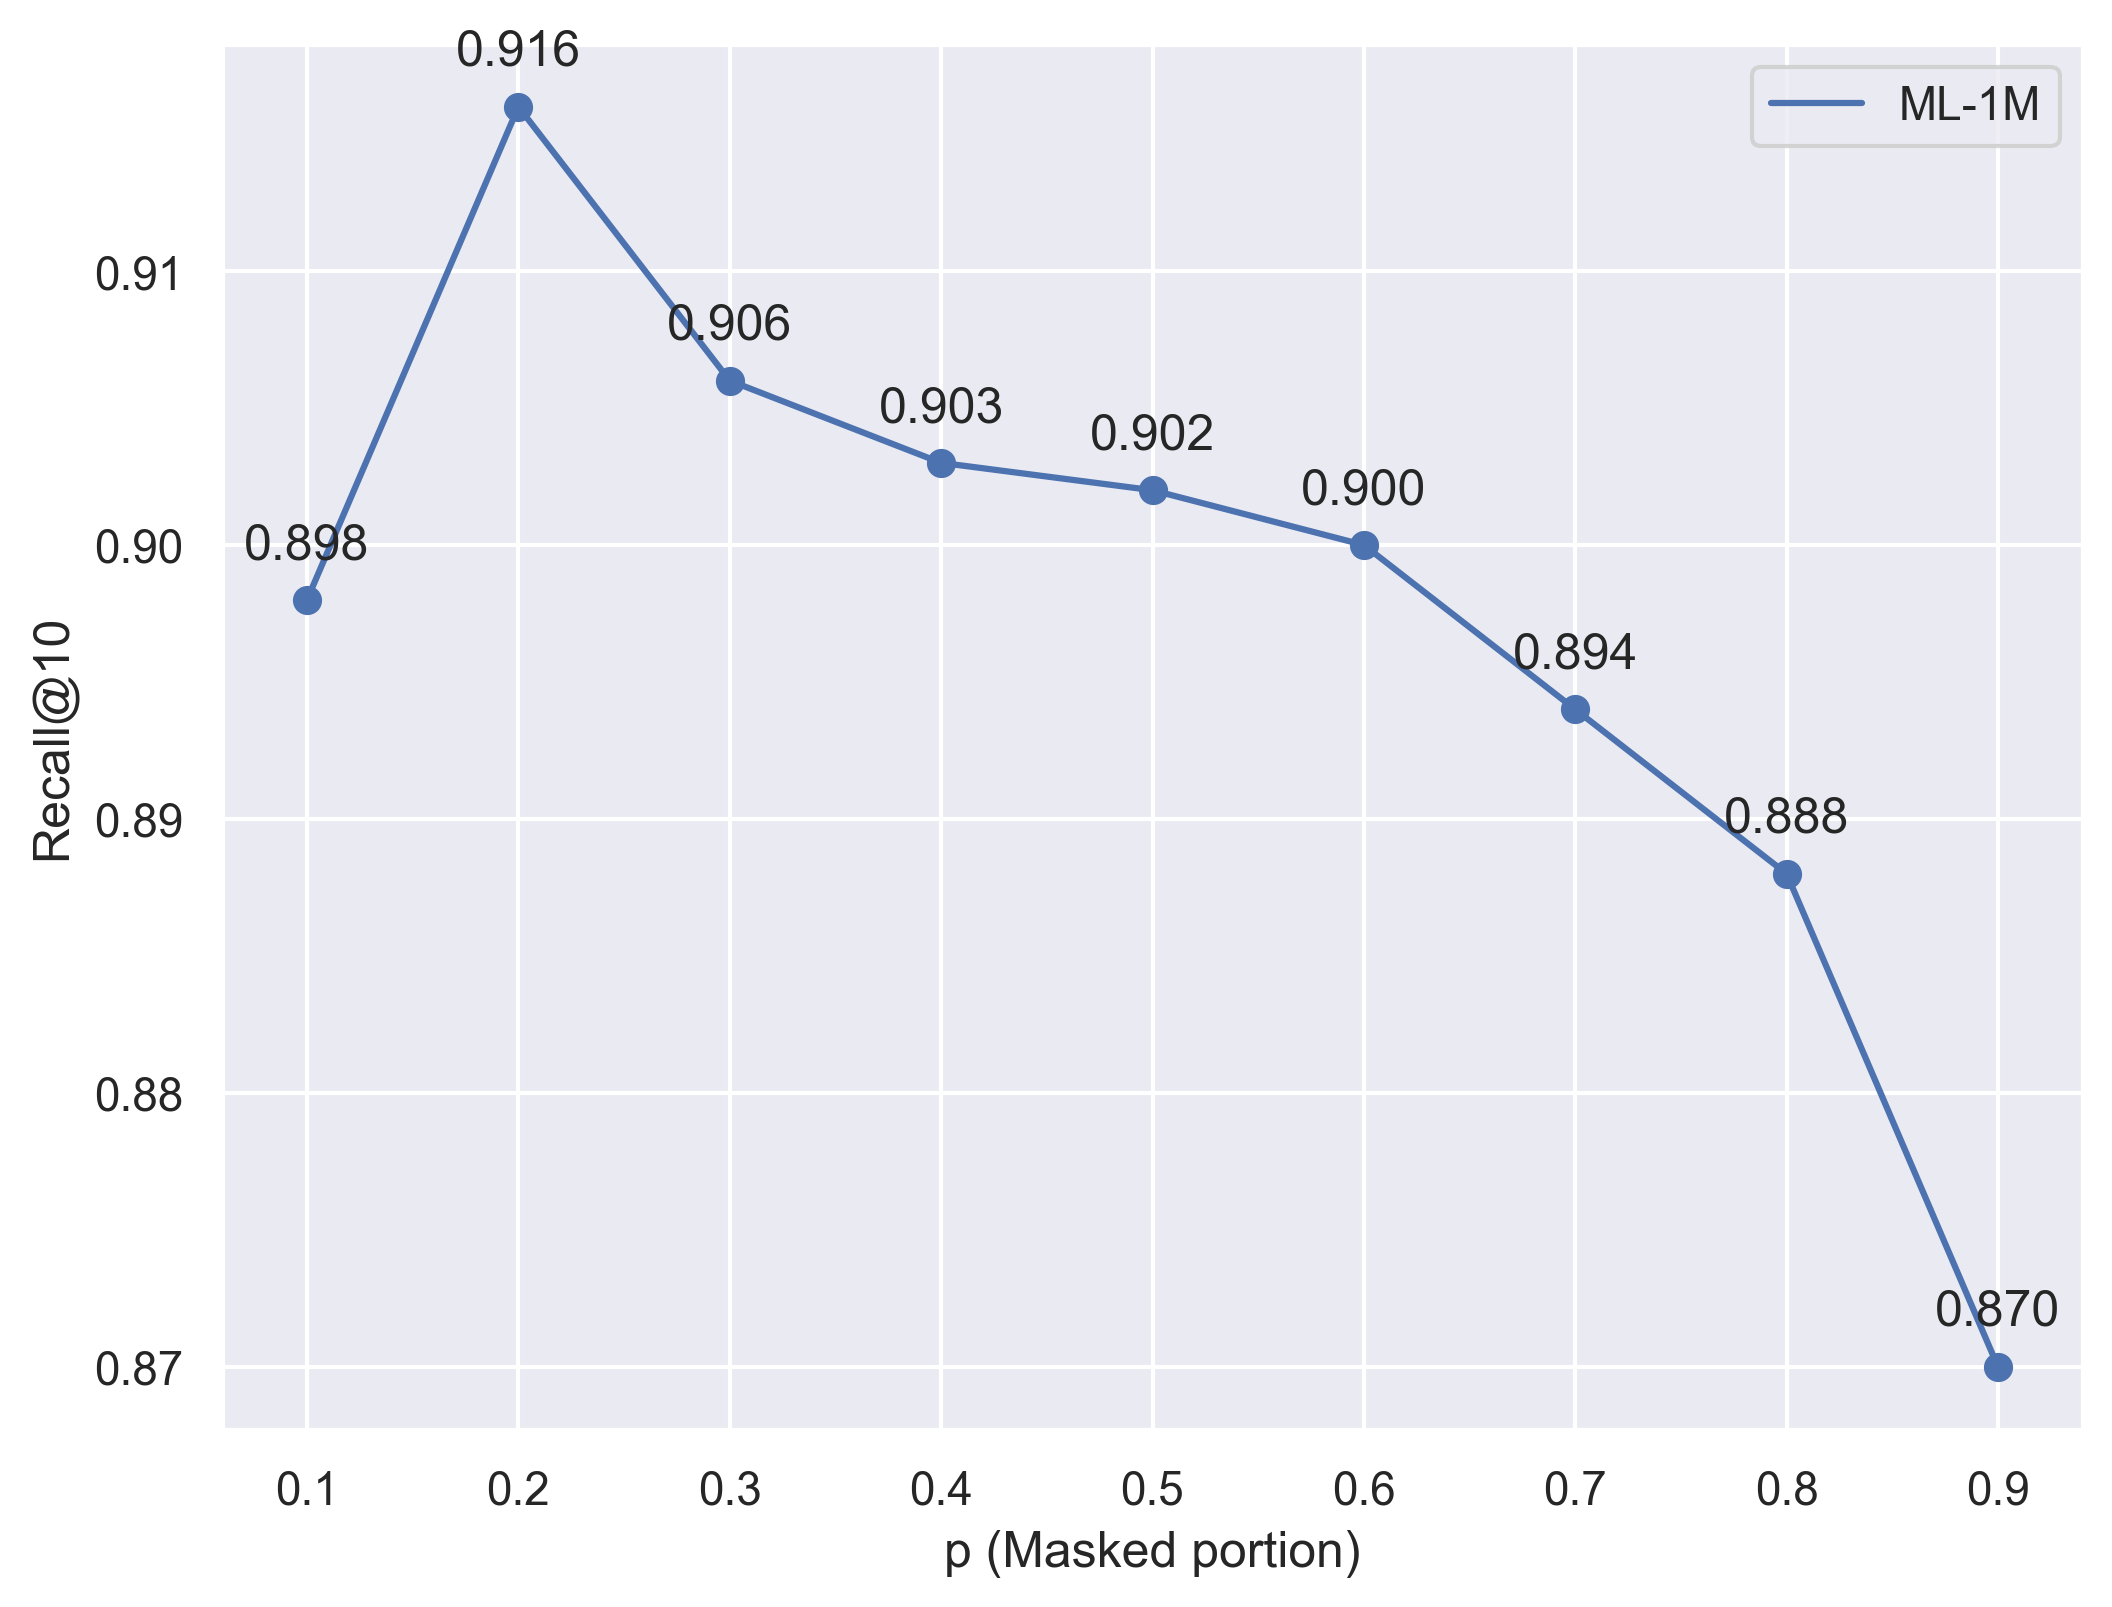

In [126]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=300)
plt.plot(p_values, recalls_50, label='ML-1M')
plt.scatter(p_values, recalls_50)

# Show the value next to each point with text
for x, y in zip(p_values, recalls_50):
    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.xlabel('p (Masked portion)')
plt.ylabel('Recall@10')
plt.legend()